# Testing your app

Once your app is running you can query it. You can simply do that by navigating to the URL that ngrok gave you above or through code in a different python session. For example, once the frontend app is running, you can navigate to:
http://YOUR_SERVER_DOMAIN/search?query=hello+world where YOUR_SERVER_DOMAIN is something like XXXX-XX-XX-XX-XX.ngrok.io, which is printed above in Colab or that is your external IP on GCP.

The code below shows how to issue a query from python. This is also how our testing code will issue queries to your search engine, so make sure to test your search engine this way after you deploy it to GCP and before submission. Command line instructions for deploying your search engine to GCP are available at `run_frontend_in_gcp.sh`. Note that we will not only issue training queries to your search engine, but also test queries, i.e. queries that you've never seen before.

In [72]:
import json

with open('queries_train.json', 'rt') as f:
  # queries = dict(list(json.load(f).items())[20:])
  queries = json.load(f)

In [55]:
def average_precision(true_list, predicted_list, k=40):
    true_set = frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    for i,doc_id in enumerate(predicted_list):        
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)            
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    return round(sum(precisions)/len(precisions),3)

In [57]:
def average_recall(true_list, predicted_list):
    true_set =frozenset(true_list)
    predicted_list = predicted_list
    summ=0
    for doc_id in true_set:        
        if doc_id in list(predicted_list):
            summ+=1
    if summ == 0:
        return 0.0
    return round(summ/len(true_list),3)

In [58]:
def avg_time_pres(qs):
  return sum([time for _,time,_,_ in qs])/len(qs),sum([pres for _,_,pres,_ in qs if pres!= None])/(len(qs)),sum([rec for _,_,_,rec in qs if rec!= None])/(len(qs))


In [59]:
def prams_to_string(parms):
  return f'title_parms: w_cosine_similarity {parms[0]}, w_boolean {parms[1]},w_BM25_b_k1_k3_baselog {parms[2:7]}     body_parms: w_cosine_similarity {parms[7]}, w_boolean {parms[8]},w_BM25_b_k1_k3_baselog {parms[9:14]} merge={parms[14]}'
  


In [60]:
import requests
from time import time
url = 'http://34.173.94.228:8080'

## **result dict by parameters**

In [76]:
result_dict={}

## **set parameters**

In [64]:
qs_res = []
p_title_cosine_similarity = 0
p_title_boolean = 0.6
p_title_BM25 = 0.7
b_title_BM25 =0
k1_title_BM25 = 1.75
k3_title_BM25 = 1.75
base_log_title_BM25 = 10

p_body_cosine_similarity = 0
p_body_boolean = 0
p_body_BM25 = 0.3
b_body_BM25 = 0.54
k1_body_BM25 = 1.84
k3_body_BM25 = 1.95
base_log_body_BM25 = 10

merge_n=230

parameters=[p_title_cosine_similarity,p_title_boolean,p_title_BM25,b_title_BM25,k1_title_BM25,k3_title_BM25,base_log_title_BM25,
            p_body_cosine_similarity,p_body_boolean,p_body_BM25,b_body_BM25,k1_body_BM25,k3_body_BM25,base_log_body_BM25,merge_n]



In [66]:
duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/set_parameters',json=parameters)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res

[True]

## **Auto Tests**


In [80]:
import random
def get_parameters(parameters):
  for i in range(len(parameters)-4):
    parameters[2]=round(random.uniform(0.5, 1),2)
    parameters[9]=1-parameters[2]
    # parameters[10]=round(random.uniform(0.4, 0.6),2)
    # parameters[11]=round(random.uniform(1, 2),2)
    # parameters[12]=round(random.uniform(1, 2),2)

    parameters[14]=random.randint(100, 250)
  return parameters

In [81]:
def set_param(parameters):
  duration, ap = None, None
  try:
    res = requests.post(url+'/set_parameters',json=parameters)
    if res.status_code == 200:
      qs_res= res.json()
  except:
    pass

In [82]:
def search():
  qs_res = []
  for q, true_wids in queries.items():
    duration, ap ,rc= None, None,None
    t_start = time()
    try:
      res = requests.get(url + '/search', {'query': q}, timeout=35)
      duration = time() - t_start
      if res.status_code == 200:
        pred_wids, _ = zip(*res.json())
        ap = average_precision(true_wids, pred_wids)
        rc = average_recall(true_wids, pred_wids)
    except:
      pass
    
    qs_res.append((q, duration, ap,rc))
  return(qs_res)

In [83]:
  for i in range(8):
    parameters = get_parameters(parameters)
    print(parameters)
    set_param(parameters)
    qs_res = search()
    result_dict[prams_to_string(parameters)] = avg_time_pres(qs_res)
    
    


[0, 0.6, 0.54, 0, 1.75, 1.75, 10, 0, 0, 0.45999999999999996, 0.54, 1.84, 1.95, 10, 211]
[0, 0.6, 0.93, 0, 1.75, 1.75, 10, 0, 0, 0.06999999999999995, 0.54, 1.84, 1.95, 10, 102]
[0, 0.6, 0.83, 0, 1.75, 1.75, 10, 0, 0, 0.17000000000000004, 0.54, 1.84, 1.95, 10, 157]
[0, 0.6, 0.92, 0, 1.75, 1.75, 10, 0, 0, 0.07999999999999996, 0.54, 1.84, 1.95, 10, 190]
[0, 0.6, 0.54, 0, 1.75, 1.75, 10, 0, 0, 0.45999999999999996, 0.54, 1.84, 1.95, 10, 242]
[0, 0.6, 0.97, 0, 1.75, 1.75, 10, 0, 0, 0.030000000000000027, 0.54, 1.84, 1.95, 10, 194]
[0, 0.6, 0.75, 0, 1.75, 1.75, 10, 0, 0, 0.25, 0.54, 1.84, 1.95, 10, 213]
[0, 0.6, 0.76, 0, 1.75, 1.75, 10, 0, 0, 0.24, 0.54, 1.84, 1.95, 10, 184]


In [39]:
result_dict


{'title_parms: w_cosine_similarity 0, w_boolean 0.6,w_BM25_b_k1_k3_baselog [0.7, 0, 1.75, 1.75, 10]     body_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0.3, 1.09, 1.19, 1.52, 10] merge=230': (2.1143392244974772,
  0.6445000000000002,
  0.17400000000000002),
 'title_parms: w_cosine_similarity 0, w_boolean 0.6,w_BM25_b_k1_k3_baselog [0.7, 0, 1.75, 1.75, 10]     body_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0.3, 0.8, 1.78, 1.6, 10] merge=230': (1.9795051256815592,
  0.6598333333333334,
  0.17400000000000002),
 'title_parms: w_cosine_similarity 0, w_boolean 0.6,w_BM25_b_k1_k3_baselog [0.7, 0, 1.75, 1.75, 10]     body_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0.3, 0.94, 1.39, 1.34, 10] merge=230': (1.9722492853800455,
  0.6483000000000002,
  0.17400000000000002),
 'title_parms: w_cosine_similarity 0, w_boolean 0.6,w_BM25_b_k1_k3_baselog [0.7, 0, 1.75, 1.75, 10]     body_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b

## **Plot Test Results** 

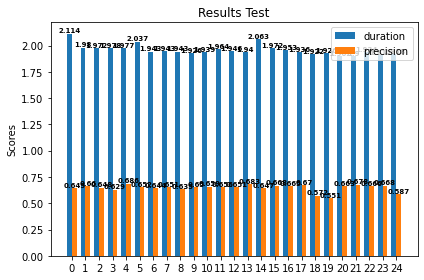

(1.9768154462178549, 0.6860666666666667, 0.17486666666666667)
title_parms: w_cosine_similarity 0, w_boolean 0.6,w_BM25_b_k1_k3_baselog [0.7, 0, 1.75, 1.75, 10]     body_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0.3, 0.54, 1.84, 1.95, 10] merge=230


In [40]:
from nltk.metrics.scores import precision
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np


labels = result_dict.keys()
duration,precision,_ = zip(*result_dict.values())


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, duration, width, label='duration')
rects2 = ax.bar(x + width/2, precision, width, label='precision')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Results Test')
ax.set_xticks(range(len(labels)))
ax.legend()

for bar in rects1:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width()/2, height, round(height,3), ha='center', va='bottom',fontsize=7,fontweight='bold')

for bar in rects2:
  height = bar.get_height()
  ax.text(bar.get_x() + bar.get_width()/2, height, round(height,3), ha='center', va='bottom',fontsize=7,fontweight='bold')
fig.tight_layout()

plt.show()
max_key = max(result_dict, key = lambda x: result_dict.get(x)[1])


print(result_dict[max_key])
print(max_key)

## **Test search**

In [73]:

# url = 'http://35.232.59.3:8080'
# place the domain you got from ngrok or GCP IP below. 


qs_res = []
for q, true_wids in queries.items():
  duration, ap,rc = None, None,None
  t_start = time()
  try:
    res = requests.get(url + '/search', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
      rc = average_recall(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap,rc))
  


In [74]:
qs_res

[('best marvel movie', 3.5919082164764404, 0.867, 0.067),
 ('How do kids come to world?', 5.807981252670288, 0.0, 0.0),
 ('Information retrieval', 0.6811745166778564, 1.0, 0.05),
 ('LinkedIn', 0.020114660263061523, 1.0, 0.533),
 ('How to make coffee?', 1.6371204853057861, 0.0, 0.0),
 ('Ritalin', 0.00716710090637207, 0.771, 0.605),
 ('How to make wine at home?', 4.238125801086426, 0.0, 0.0),
 ('Most expensive city in the world', 7.430591106414795, 0.28, 0.283),
 ('India', 1.6609418392181396, 0.661, 0.592),
 ('how to make money fast?', 2.60622501373291, 1.0, 0.03),
 ('Netflix', 0.10111236572265625, 1.0, 0.059),
 ('Apple computer', 0.9611873626708984, 0.697, 0.119),
 ('The Simpsons', 0.04854869842529297, 1.0, 0.154),
 ('World cup', 5.335737705230713, 0.622, 0.455),
 ('How to lose weight?', 0.8475992679595947, 1.0, 0.045),
 ('Java', 0.1381666660308838, 0.95, 0.435),
 ('Air Jordan', 1.8233389854431152, 1.0, 0.103),
 ('how to deal with depression?', 0.7712149620056152, 1.0, 0.02),
 ('How do 

In [75]:
avg_time_pres(qs_res)

(1.9478399674097697, 0.6899333333333332, 0.17623333333333335)

In [52]:
result_dict[prams_to_string(parameters)] = avg_time_pres(qs_res)

In [53]:
result_dict 

{'title_parms: w_cosine_similarity 0, w_boolean 0.6,w_BM25_b_k1_k3_baselog [0.7, 0, 1.75, 1.75, 10]     body_parms: w_cosine_similarity 0, w_boolean 0,w_BM25_b_k1_k3_baselog [0.3, 0.54, 1.84, 1.95, 10] merge=230': (1.7443791627883911,
  0.7034,
  0.1674)}

## **Test search_body**

In [ ]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_body', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

[('best marvel movie', 2.6888821125030518, 0.221),
 ('How do kids come to world?', 4.359713792800903, 0.037),
 ('Information retrieval', 1.2467851638793945, 0.376),
 ('LinkedIn', 0.32838964462280273, 0.815),
 ('How to make coffee?', 1.7823688983917236, 0.505),
 ('Ritalin', 0.32057785987854004, 0.712),
 ('How to make wine at home?', 3.7062108516693115, 0.249),
 ('Most expensive city in the world', 6.143420457839966, 1.0),
 ('India', 1.1721875667572021, 0.263),
 ('how to make money fast?', 2.4201366901397705, 0.276),
 ('Netflix', 0.3690643310546875, 0.712),
 ('Apple computer', 0.822045087814331, 0.508),
 ('The Simpsons', 0.3415541648864746, 0.192),
 ('World cup', 4.317164659500122, 0.54),
 ('How to lose weight?', 0.7297241687774658, 0.288),
 ('Java', 0.3810234069824219, 0.407),
 ('Air Jordan', 1.3638386726379395, 0.421),
 ('how to deal with depression?', 0.9454023838043213, 0.323),
 ('How do you make gold', 2.374253273010254, 0.385),
 ('Marijuana', 0.3480856418609619, 0.081),
 ('How to m

In [ ]:
avg_time_pres(qs_res)

(1.749275835355123, 0.3849666666666666)

## **Test search_title**

In [ ]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_title', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

[('best marvel movie', 1.186560869216919, 0.0),
 ('How do kids come to world?', 1.6448984146118164, 0.097),
 ('Information retrieval', 0.8095262050628662, 0.817),
 ('LinkedIn', 0.31943368911743164, 1.0),
 ('How to make coffee?', 0.6507124900817871, 0.284),
 ('Ritalin', 0.3190593719482422, 1.0),
 ('How to make wine at home?', 0.9993784427642822, 0.0),
 ('Most expensive city in the world', 1.8301446437835693, 0.25),
 ('India', 1.003746747970581, 0.433),
 ('how to make money fast?', 0.8107409477233887, 0.616),
 ('Netflix', 0.3197157382965088, 0.557),
 ('Apple computer', 0.8113000392913818, 0.622),
 ('The Simpsons', 0.32015538215637207, 0.546),
 ('World cup', 1.8495383262634277, 0.408),
 ('How to lose weight?', 0.47997331619262695, 0.0),
 ('Java', 0.4779019355773926, 0.642),
 ('Air Jordan', 1.1833832263946533, 0.756),
 ('how to deal with depression?', 0.4838869571685791, 0.0),
 ('How do you make gold', 0.9706940650939941, 0.416),
 ('Marijuana', 0.3211393356323242, 0.842),
 ('How to make hu

In [ ]:
avg_time_pres(qs_res)

(0.8408629496892294, 0.47476666666666667)

## **Test search_anchor**

In [ ]:
qs_res = []
for q, true_wids in queries.items():
  duration, ap = None, None
  t_start = time()
  try:
    res = requests.get(url + '/search_anchor', {'query': q}, timeout=35)
    duration = time() - t_start
    if res.status_code == 200:
      pred_wids, _ = zip(*res.json())
      ap = average_precision(true_wids, pred_wids)
  except:
    pass
  
  qs_res.append((q, duration, ap))

In [ ]:
qs_res

[('best marvel movie', 2.5895748138427734, 0.211),
 ('How do kids come to world?', 3.4236786365509033, 0.0),
 ('Information retrieval', 1.4278738498687744, 0.539),
 ('LinkedIn', 0.8411605358123779, 0.0),
 ('How to make coffee?', 1.3876454830169678, 0.0),
 ('Ritalin', 0.34062910079956055, 1.0),
 ('How to make wine at home?', 1.9492156505584717, 0.0),
 ('Most expensive city in the world', 5.010385751724243, 0.0),
 ('India', 1.7032344341278076, 0.0),
 ('how to make money fast?', 1.3944618701934814, 0.0),
 ('Netflix', 1.1800377368927002, 0.0),
 ('Apple computer', 1.8347883224487305, 0.058),
 ('The Simpsons', 0.859311580657959, 0.0),
 ('World cup', 4.478655576705933, 0.0),
 ('How to lose weight?', 0.6719150543212891, 1.0),
 ('Java', 1.0633227825164795, 0.0),
 ('Air Jordan', 2.4306509494781494, 0.0),
 ('how to deal with depression?', 1.1879346370697021, 0.0),
 ('How do you make gold', 1.6291918754577637, 0.0),
 ('Marijuana', 0.3364853858947754, 0.408),
 ('How to make hummus', 1.1945891380310

In [ ]:
avg_time_pres(qs_res)

(1.7113134225209554, 0.18663333333333335)

## **Test Page Rank**

In [ ]:
qs_res = []
lst = [100,200,300,565677,54656,89897]

duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/get_pagerank',json=lst)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res

[[100, 0.0],
 [200, 0.0],
 [300, 0.0],
 [565677, 0.5988047365295416],
 [54656, 0.0],
 [89897, 0.0]]

## **Test Page View**

In [ ]:
qs_res = []
lst = [100,200,300,565677,54656,89897]

duration, ap = None, None
t_start = time()
try:
  res = requests.post(url+'/get_pageview',json=lst)
  duration = time() - t_start
  if res.status_code == 200:
    qs_res= res.json()
except:
  pass
  
qs_res

[[100, 0.0],
 [200, 0.0],
 [300, 0.0],
 [565677, 1719],
 [54656, 0.0],
 [89897, 0.0]]